# Prueba Final, Bootcamp Fundamentos DS, Academia Desafio Latam, Agosto 2018

## Primer Problema

### Preliminares

El objetivo es generar un modelo predictivo sobre la probabilidad que un individuo presente salarios por sobre o bajo los 50.000 dólares anuales, en base a una serie de atributos sociodemográficos. Dado que se trata de una variable binaria (>50k, <50k), se utilizará un modelo de regresión logística, utilizando como métricas de desempeño F1 y el área bajo la curva ROC. Para depurar el modelo, primero se hará un análisis descriptivo de sus variables, y luego se ejecutará un modelamiento descriptivo, para conocer cuales son sus variables más significativas.

### Aspectos computacionales


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import PolynomialFeatures
import warnings
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
warnings.filterwarnings(action="ignore")
import functions as fxpy

Se trae la tríada de bibliotecas de DS (pandas, numpy y matplotlib), además de seaborn para ayudarnos en los gráficos. Por otro lado, se trae statsmodels para poder generar el modelo descriptivo y bibliotecas de sklearn para implementar el modelo de regresión y medir sus métricas de desempeño.
Finalmente, se crearon funciones especialmente para este notebook, que nos ayudarán a generar gráficos para todo el df y no trabajar columna a columna.

### Descripción

Primero leemos el archivo income-db.csv, reemplazando los valores '?' por NaN. Ademśa recodificamos las variables 'occupation', 'workclass', 'education' y marital status

In [2]:
df = pd.read_csv('income-db.csv').replace('?', np.nan)

df['collars'] = df['occupation']
df['collars'] = df['collars'].replace(['Prof-specialty', 'Exec-managerial', 'Adm-clerical', 'Sales', 'Tech-support'], 'white-collar')
df['collars'] = df['collars'].replace(['Craft-repair', 'Machine-op-inspct', 'Transport-moving', 'Handlers-cleaners', 'Farming-fishing', 'Protective-serv', 'Priv-house-serv'], 'blue-collar')
df['collars'] = df['collars'].replace(['Other-service', 'Armed-Forces'], 'others')

df['workclass_recod'] = df['workclass']
df['workclass_recod'] = df['workclass_recod'].replace(['Federal-gov'], 'federal-gov')
df['workclass_recod'] = df['workclass_recod'].replace(['State-gov','Local-gov'], 'state-level-gov')
df['workclass_recod'] = df['workclass_recod'].replace(['Self-emp-not-inc','Self-emp-inc'], 'self-employed')
df['workclass_recod'] = df['workclass_recod'].replace(['Never-worked','Without-pay'], 'unemployed')

df['educ_recod'] = df['education']
df['educ_recod'] = df['educ_recod'].replace(['Preschool'], 'preschool')
df['educ_recod'] = df['educ_recod'].replace(['1st-4th', '5th-6th'], 'elementary-school')
df['educ_recod'] = df['educ_recod'].replace(['7th-8th', '9th', '10th','11th', '12th', 'HS-grad'], 'high-school')
df['educ_recod'] = df['educ_recod'].replace(['Assoc-voc', 'Assoc-acdm', 'Some-college'], 'college')
df['educ_recod'] = df['educ_recod'].replace(['Bachelors', 'Masters', 'Prof-school', 'Doctorate'], 'university')

df['civstatus'] = df['marital-status']
df['civstatus'] = np.where(df['civstatus'].str.contains('Married'),'married',df['civstatus'])
df['civstatus'] = df['civstatus'].str.lower()

Ahora utilizando el archivo paises.csv clasificamos por regiones y binarizamos la variable 'income'

In [3]:
paises = pd.read_csv('paises.csv')

paises = paises.rename(columns={'continente': 'region'})

df = df.merge(paises, left_on='native-country', right_on='pais')

df['income'] = np.where(df['income']=='<=50K',0,1)

In [4]:
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income
count,47985.000000,4.798500e+04,47985.000000,47985.000000,47985.000000,47985.000000,47985.000000
mean,38.641284,1.895940e+05,10.067229,1067.032093,87.370553,40.411483,0.238971
std,13.729622,1.057605e+05,2.560534,7373.256663,402.681462,12.391073,0.426459
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.173490e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781000e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.377200e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


Notamos que en las variables numéricas tenemos todos los datos, pero que las variables capital-gain y capital-loss se comportan de manera extraña, ya que más de un 75% de los datos están en 0.

In [5]:
df.describe(exclude=np.number)

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,collars,workclass_recod,educ_recod,civstatus,pais,region
count,45232,47985,47985,45222,47985,47985,47985,47985,45222,45232,47985,47985,47985,47870
unique,8,16,7,14,6,5,2,41,3,5,5,5,41,3
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,white-collar,Private,high-school,married,United-States,America
freq,33307,15586,21971,6020,19371,41189,32041,43832,24360,33307,21069,22603,43832,46109


Notamos que los numeros de datos difieren de variable en variable, lo que puede significar valores perdidos. Estados uUnidos es el que tiene mayor representación, con 43832 datos de un total de 47985. Eventualmente esto puede significar que esté sobrerrepresentado y que nuestros modelos puedan predecir muy bien la situación en USA pero no en otros países, lo mismo para las razas

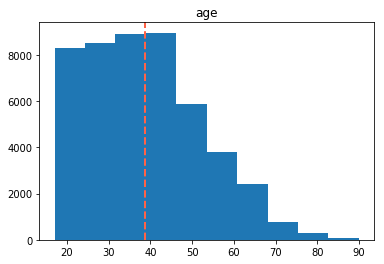

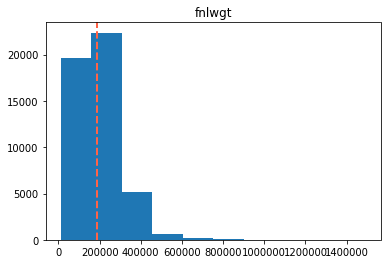

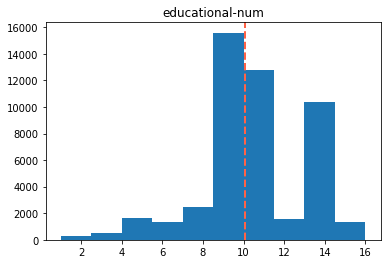

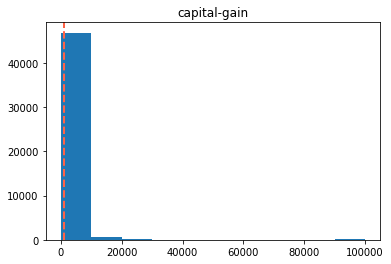

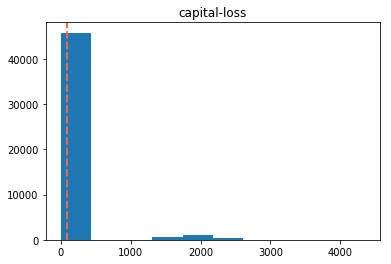

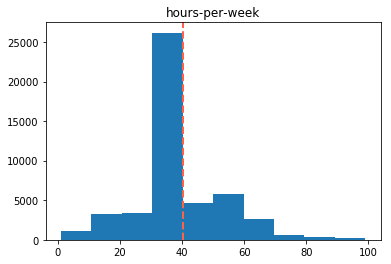

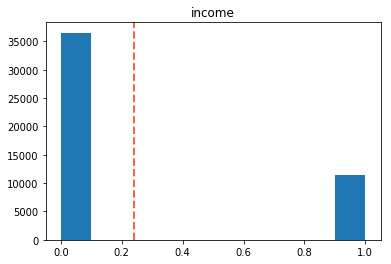

In [6]:
fxpy.histograms(df)

Si bien la mayor parte de las variables están concentradas cerca de la media, no hay ninguna que se comporte de forma parecida a la normal. Las variables capitalgain y capitalloss tienen la mayor parte de datos con valor 0. Graficaremos boxplots para revisar si hay outliers

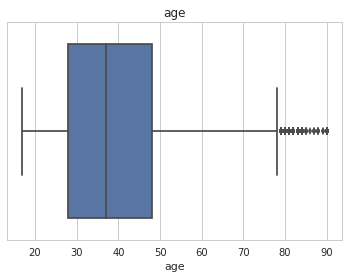

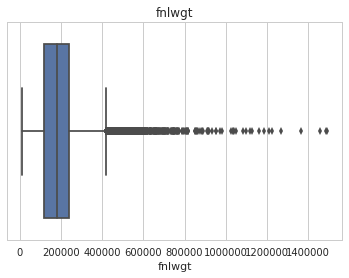

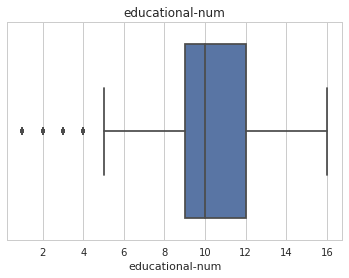

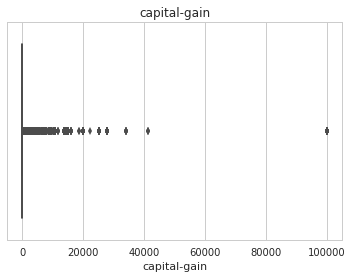

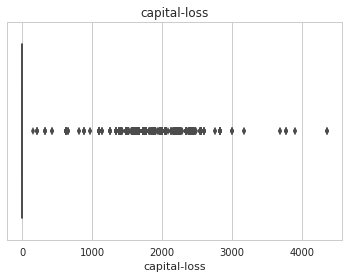

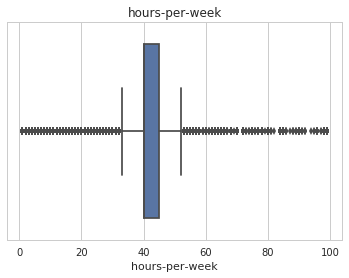

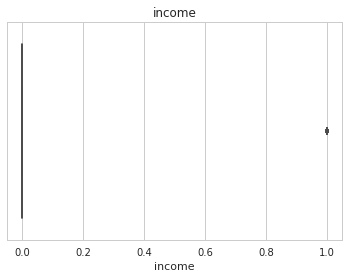

In [10]:
fxpy.boxplots(df)

Las variales fnlwgt, capital gain, capital loss, hours per week presentan una gran cantidad de Outliers.  
    Ahora contemos la cantidad de datos perdidos que tenemos

In [11]:
fxpy.valores_ds1(df)

workclass :
Private             33307
Self-emp-not-inc     3796
Local-gov            3100
NaN                  2753
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


education :
HS-grad         15586
Some-college    10723
Bachelors        7815
Masters          2579
Assoc-voc        2038
11th             1800
Assoc-acdm       1579
10th             1372
7th-8th           931
Prof-school       808
9th               745
12th              635
Doctorate         562
5th-6th           490
1st-4th           240
Preschool          82
Name: education, dtype: int64


marital-status :
Married-civ-spouse       21971
Never-married            15816
Divorced                  6561
Separated                 1507
Widowed                   1498
Married-spouse-absent      595
Married-AF-spouse           37
Name: marital-status, dtype: int64


occupation :
Craft-repair         6020
Prof-specialty  

occupation, collars, workclass y region tienen altos valores de missing values, los agruparé por regiṕn para saber si es pérdida aleatoria o está concentrada en alguna región en particular

In [14]:
fxpy.valores_ds1_grouped(df)

workclass :
region   workclass       
America  Private             0.693834
         Self-emp-not-inc    0.078770
         Local-gov           0.065670
         NaN                 0.057386
         State-gov           0.040513
         Self-emp-inc        0.033855
         Federal-gov         0.029322
         Without-pay         0.000434
         Never-worked        0.000217
Asia     Private             0.723751
         Self-emp-not-inc    0.059123
         State-gov           0.056065
         NaN                 0.051988
         Self-emp-inc        0.037717
         Local-gov           0.035678
         Federal-gov         0.034659
         Without-pay         0.001019
Europa   Private             0.701282
         Self-emp-not-inc    0.100000
         NaN                 0.053846
         Local-gov           0.047436
         Self-emp-inc        0.046154
         State-gov           0.028205
         Federal-gov         0.023077
Name: workclass, dtype: float64


education :
regi

region   pais                      
America  United-States                 0.950617
         Mexico                        0.020625
         Puerto-Rico                   0.003991
         Canada                        0.003947
         El-Salvador                   0.003362
         Cuba                          0.002993
         Jamaica                       0.002299
         Dominican-Republic            0.002234
         Guatemala                     0.001909
         Columbia                      0.001843
         Haiti                         0.001627
         Nicaragua                     0.001063
         Peru                          0.000998
         Ecuador                       0.000976
         Trinadad&Tobago               0.000586
         Outlying-US(Guam-USVI-etc)    0.000499
         Honduras                      0.000434
Asia     Philippines                   0.300714
         India                         0.153925
         China                         0.124363
    

En promedio, los "missing-values" son un 5% en cada región, lo que nos asegura que si los eliminamos no estamos dejando a una región subrepresentada (más de lo que ya está la muestra original), decidimos eliminar todos los datos nulos.
REcodificamos a variables binarias.

In [15]:
df['female'] = np.where(df['gender'] == 'Female', 1, 0)
df_drop = df.dropna()
df_drop.columns = df_drop.columns.map(lambda x: str(x).lower().replace('-', '_'))
df_drop.head()
df_dummies = pd.get_dummies(df_drop, columns=['region','collars','educ_recod','civstatus'])
df_dummies.columns = df_dummies.columns.map(lambda x: str(x).lower().replace('-', '_'))
df_dummies = df_dummies.dropna()


### Modelación descriptiva  
Decidimos utilizar una regresión logística para predecir la variable binaria 'income'

In [16]:
model1 = smf.logit('income ~ age + fnlwgt + educational_num + capital_gain + capital_loss + hours_per_week + female + region_america + region_europa + collars_blue_collar + collars_others + educ_recod_college + educ_recod_elementary_school + educ_recod_high_school + educ_recod_preschool + civstatus_divorced + civstatus_married + civstatus_never_married + civstatus_separated', data = df_dummies).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.337908
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 income   No. Observations:                45121
Model:                          Logit   Df Residuals:                    45101
Method:                           MLE   Df Model:                           19
Date:                Sat, 11 Aug 2018   Pseudo R-squ.:                  0.3967
Time:                        01:10:20   Log-Likelihood:                -15247.
converged:                       True   LL-Null:                       -25273.
                                        LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -7.8339      0.289    -27.143      0.000      -8.400      -7.268
age                              0.0244      0.001     18.768      0.000       0.022       0.027
fnlwgt                        7.016e-07   1.37e-07      5.107      0.000    4.32e-07    9.71e-07
educational_num                  0.2829      0.016     17.735      0.000       0.252       0.314
capital_gain                     0.0003   8.61e-06     37.544      0.000       0.000       0.000
capital_loss                     0.0007   3.07e-05     21.697      0.000       0.001       0.001
hours_per_week                   0.0282      0.001     21.951      0.000       0.026       0.031
female                          -0.2950      0.042     -7.089      0.000      -0.377      -0.213
region_america                   0.2612      0.098      2.675      0.007       0.070       0.453
region_europa                    0.4393      0.142      3.095      0.002       0.161       0.717
collars_blue_collar             -0.6407      0.035    -18.236      0.000      -0.710      -0.572
collars_others                  -1.3546      0.085    -15.954      0.000      -1.521      -1.188
educ_recod_college              -0.0794      0.060     -1.316      0.188      -0.198       0.039
educ_recod_elementary_school     0.0534      0.265      0.202      0.840      -0.465       0.572
educ_recod_high_school          -0.1347      0.086     -1.574      0.116      -0.303       0.033
educ_recod_preschool            -4.8023      5.995     -0.801      0.423     -16.553       6.948
civstatus_divorced              -0.0030      0.126     -0.024      0.981      -0.250       0.244
civstatus_married                2.1509      0.121     17.839      0.000       1.915       2.387
civstatus_never_married         -0.5082      0.128     -3.961      0.000      -0.760      -0.257
civstatus_separated             -0.0714      0.168     -0.424      0.671      -0.401       0.258
================================================================================================
"""

En primera instancia notamos que hay variables no significativas, como educ_recod, civstatus_divorced y civstatus separated. Es interesante que las variables educativas no son significativas, probablemente porque ya se encuentra la variable educational number.  
El hecho de que la región sea de Europa, influye casi en el doble que si la región es americana. Por otro lado, el hecho de haberse casado también influye positivamente, en cambio los no casados al parecer tienen menor probabilidad de tener ingresos sobre 50k

### Modelación descriptiva

Utilizaremos un modelo saturado para la primera iteración

In [28]:

X_train, X_test, y_train, y_test = train_test_split(df_dummies[['age','educational_num','capital_gain','capital_loss','hours_per_week','female','region_asia', 'region_europa', 'collars_blue_collar', 'collars_others',
       'educ_recod_college',
       'educ_recod_elementary_school', 'educ_recod_high_school',
       'educ_recod_preschool', 'civstatus_divorced',
       'civstatus_married', 'civstatus_never_married', 'civstatus_separated']],
                                                   df_dummies['income'],
                                                   test_size=.33,
                                                   random_state=3249436)


# estandarizamos la matriz de entrenamiento
X_train_std = StandardScaler().fit_transform(X_train)
# estandarizamos la matriz de validación
X_test_std = StandardScaler().fit_transform(X_test)

# iniciamos el modelo con la clase LogisticRegression y pasamos los datos en fit.
default_model = LogisticRegression().fit(X_train_std, y_train)

yhat = default_model.predict(X_test_std)
m1_confusion = confusion_matrix(y_test, yhat)
print('Matriz de confusión: \n',m1_confusion)
print('\n Classification Report: \n')
print(classification_report(y_test, yhat))

Matriz de confusión: 
 [[10406   821]
 [ 1466  2197]]

 Classification Report: 

             precision    recall  f1-score   support

          0       0.88      0.93      0.90     11227
          1       0.73      0.60      0.66      3663

avg / total       0.84      0.85      0.84     14890



Los verdaderos positivos y negativos son mucho mayores que los falsos positivos y negativos. Por otro lado, nuestro puntaje f1 es de un 0.84 %. Revisemos la curva ROC:

El área bajo la curva es: 0.9


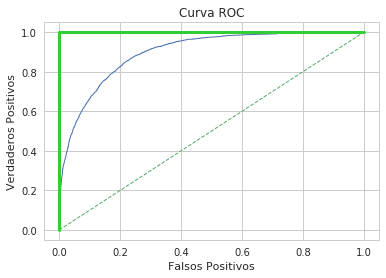

In [29]:
# reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
yhat = default_model.predict_proba(X_test_std)[:, 1]
# generamos los objetos de roc_cruve
false_positive, true_positive, threshold = roc_curve(y_test, yhat)
# Plot ROC curve
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');
from sklearn.metrics import roc_auc_score
print('El área bajo la curva es:',round(roc_auc_score(y_test, yhat),2))

0.9 habla muy bien de nuestro modelo predictivo (0.4 más efectivo que el caso aleatorio)  
Depuraremos nuestro modelo ahora para intentar mejorarlo. Utilizaremos solo las variables significativas

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies[['age','educational_num','capital_gain','capital_loss','hours_per_week','female','region_asia', 'region_europa', 'collars_blue_collar', 'collars_others',
    
       'civstatus_married', 'civstatus_never_married']],
                                                   df_dummies['income'],
                                                   test_size=.33,
                                                   random_state=3249436)


# estandarizamos la matriz de entrenamiento
X_train_std = StandardScaler().fit_transform(X_train)
# estandarizamos la matriz de validación
X_test_std = StandardScaler().fit_transform(X_test)

# iniciamos el modelo con la clase LogisticRegression y pasamos los datos en fit.
default_model = LogisticRegression().fit(X_train_std, y_train)

yhat = default_model.predict(X_test_std)
m1_confusion = confusion_matrix(y_test, yhat)
print('Matriz de confusión: \n',m1_confusion)
print('\n Classification Report: \n')
print(classification_report(y_test, yhat))

Matriz de confusión: 
 [[10408   819]
 [ 1466  2197]]

 Classification Report: 

             precision    recall  f1-score   support

          0       0.88      0.93      0.90     11227
          1       0.73      0.60      0.66      3663

avg / total       0.84      0.85      0.84     14890



EL modelo es muy similar, pero mejoramos su predicción en 2 casos positivos

El área bajo la curva es: 0.9


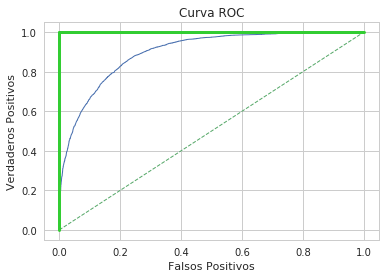

In [34]:
# reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
yhat = default_model.predict_proba(X_test_std)[:, 1]

# generamos los objetos de roc_cruve
false_positive, true_positive, threshold = roc_curve(y_test, yhat)
# Plot ROC curve
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');
from sklearn.metrics import roc_auc_score
print('El área bajo la curva es:',round(roc_auc_score(y_test, yhat),2))

La curva ROC es similar también

Para el 3er modelo compararemos un modelo polinomial de segundo grado, utilizando las mismas variables del modelo anterior (estadísticamente significativas)


In [ ]:
std_matrix = StandardScaler().fit_transform(df_dummies[['age','educational_num','capital_gain','capital_loss','hours_per_week','female','region_asia', 'region_europa', 'collars_blue_collar', 'collars_others',
    
       'civstatus_married', 'civstatus_never_married']])
polynomial_order = [1,2,3]
# por cada elemento del array
for i in polynomial_order:
    #generamos muestras segmentadas
    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(std_matrix,
                                                   df_dummies['income'],
                                                   test_size=.33,
                                                   random_state=3249436)
    # Transformamos la muestra de entrenamiento por i polinomio
    X_train_tmp = PolynomialFeatures(degree=i,
                                     interaction_only=False,
                                     include_bias=False).fit_transform(X_train_tmp)
    # Transformamos la muestra de evaluación por i polinomio
    X_test_tmp = PolynomialFeatures(degree=i,
                                    interaction_only=False,
                                    include_bias=False).fit_transform(X_test_tmp)
    # Generamos el modelo predictivo
    tmp_model = LogisticRegression().fit(X_train_tmp, y_train_tmp)
    # Guardamos las predicciones de probabilidad
    tmp_pred = tmp_model.predict_proba(X_test_tmp)[:,1]
    
    #Generamos la matriz de confusión y el reporte de clasificación
    yhat = tmp_model.predict(X_test_tmp)
    m1_confusion = confusion_matrix(y_test_tmp, yhat)
   
 
    # generamos los arrays con roc_curve
    false_positive, true_positive, threshold = roc_curve(y_test_tmp,
                                                         tmp_pred)
 

    # redondeamos los valores del puntaje AUC
    roc_auc_tmp = round(roc_auc_score(y_test_tmp, tmp_pred), 3)
    # graficamos
    plt.plot(false_positive,
             true_positive,
             label = 'Orden: {0} - AUC: {1}'.format(i, roc_auc_tmp))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c='limegreen', lw=3),
    plt.plot([1, 1] , c='limegreen', lw=3)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    # solicitamos información de iteración
    print("Orden: {0}, cantidad de atributos estimables: {1}. AUC estimada: {2}".format(i, X_train_tmp.shape[1], roc_auc_tmp))    
    print('Matriz de confusión: \n',m1_confusion)
    print('\n Classification Report: \n')
    print(classification_report(y_test, yhat))

Orden: 1, cantidad de atributos estimables: 12. AUC estimada: 0.899
Matriz de confusión: 
 [[10405   822]
 [ 1463  2200]]

 Classification Report: 

             precision    recall  f1-score   support

          0       0.88      0.93      0.90     11227
          1       0.73      0.60      0.66      3663

avg / total       0.84      0.85      0.84     14890

Orden: 2, cantidad de atributos estimables: 90. AUC estimada: 0.906
Matriz de confusión: 
 [[10385   842]
 [ 1367  2296]]

 Classification Report: 

             precision    recall  f1-score   support

          0       0.88      0.93      0.90     11227
          1       0.73      0.63      0.68      3663

avg / total       0.85      0.85      0.85     14890



El modelo polinomial mejora el f1 en 0.01 y el área roc en 0.007. Tenemos menos verdaderos positivos pero es mejor predictor en el caso de los casos negativos. De todas maneras, nuestras métricas son la curva ROC y el F1, por lo que el modelo mejor comportado es el N°3, sólo variables relevantes y polinomial de grado 2

## Segundo Problema

### Preliminares
El objetivo es generar un modelo predictivo que identifique aquellos alumnos que presentan un bajo desempeño académico. En este caso desarrollaremos una descripción y un modelo descriptivo de la muestra, para luego realizar una regresión lineal basada en los atributos más relevantes encontrados en la parte descriptiva. Para elegir el mejor modelo de regresión ocuparemos el MSE
### Aspectos computacionales

# PENDIENTE

## Descripción

Leemos el archivo csv y pasamos las variables age, health y goout a numéricas

In [2]:
df = pd.read_csv('students.csv', sep = '|',index_col=0).replace(['sem validade', 'nulidade', 'zero'], np.nan).dropna()
for i in ['age','health','goout','Medu','Fedu','traveltime','studytime','failures','famrel','freetime','absences','Dalc','Walc','G1','G3']:

    df[i] = df[i].str.replace('\"', '').astype(int)

In [21]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [47]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.00000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,16.707746,2.774648,2.521127,1.475352,2.049296,0.334507,3.940141,3.18662,3.084507,1.482394,2.239437,3.626761,5.588028,10.933099,10.640845,10.394366
std,1.284238,1.095409,1.091038,0.695334,0.843411,0.730994,0.881659,1.02117,1.076527,0.879512,1.285580,1.319113,8.156335,3.289199,3.789220,4.565902
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.00000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.00000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,10.500000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.00000,4.000000,2.000000,3.000000,5.000000,7.000000,13.000000,13.000000,13.000000
max,21.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


Tenemos 284 observaciones, con una media de dedad de 16,7 años. Se vislumbra una gran varianza en la variable 'absences' y haremos una observación de histogramas para ver de que forma se distribuyen las variables

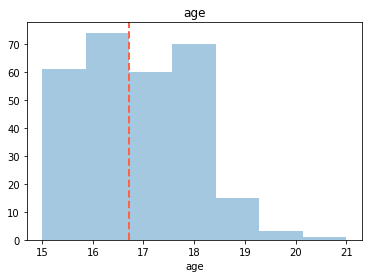

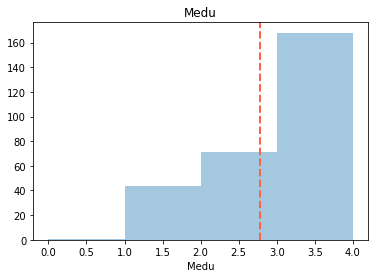

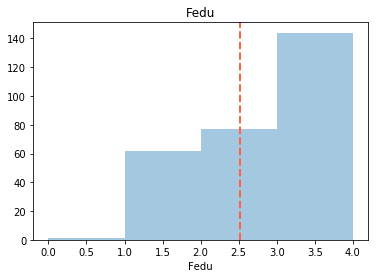

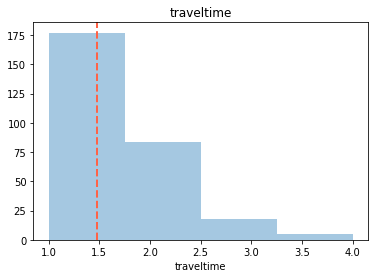

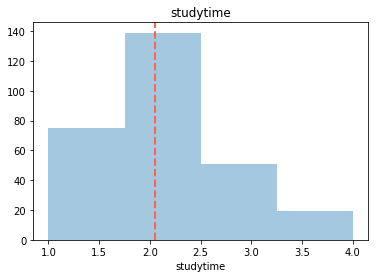

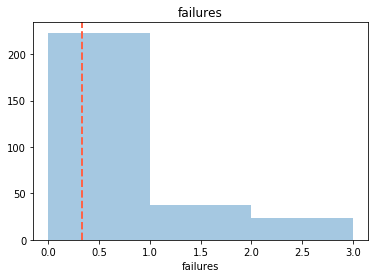

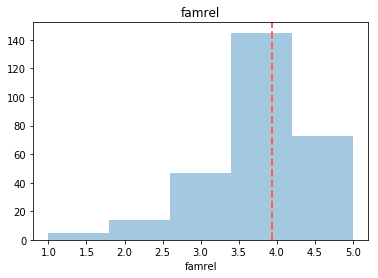

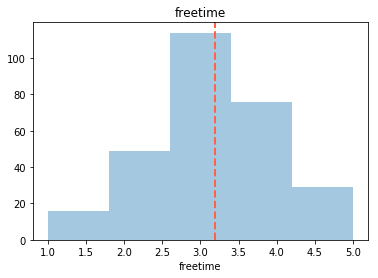

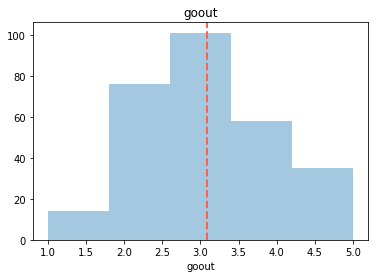

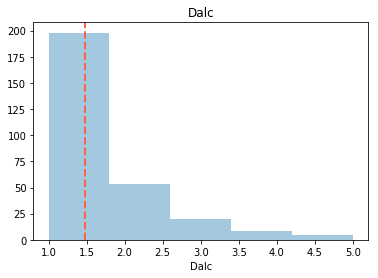

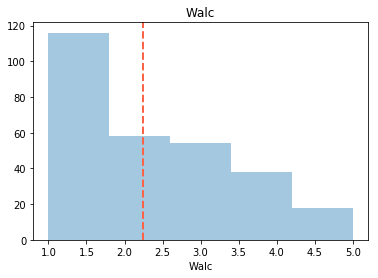

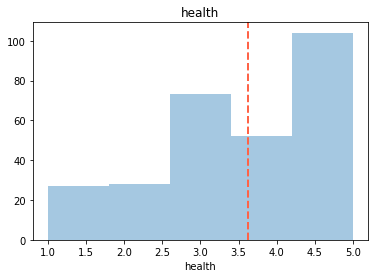

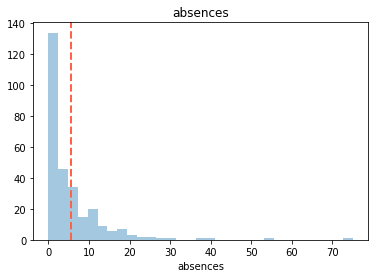

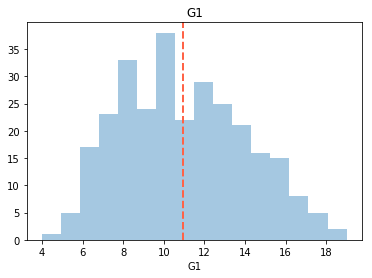

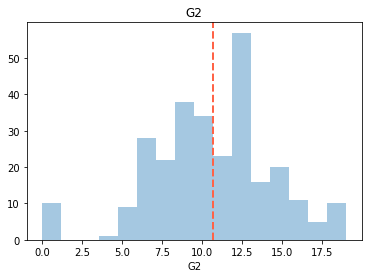

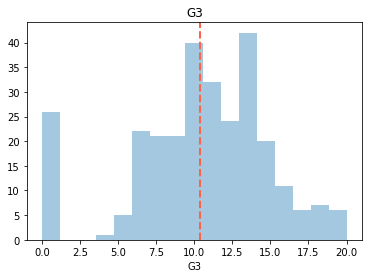

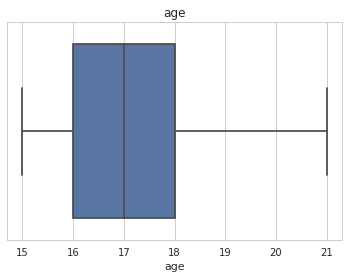

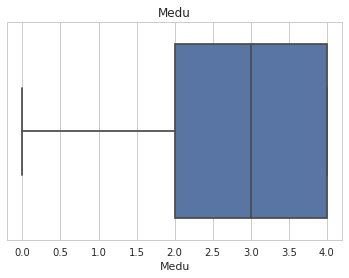

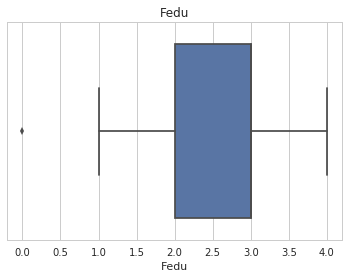

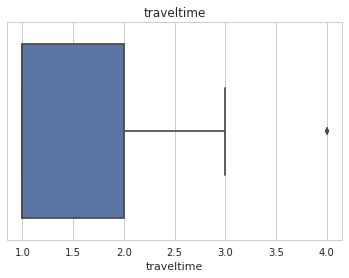

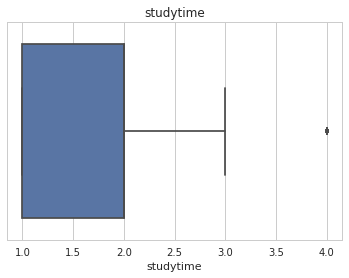

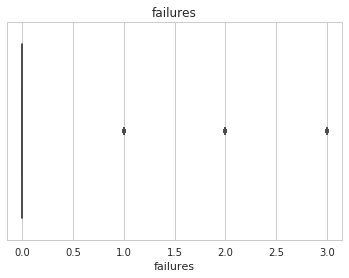

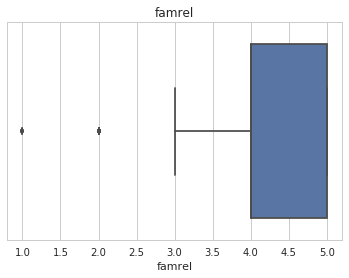

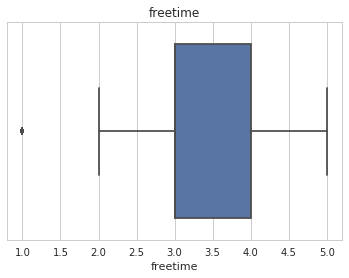

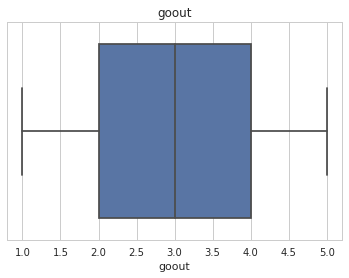

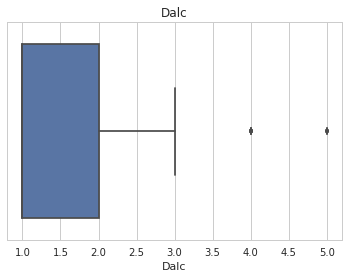

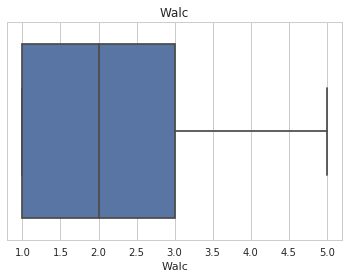

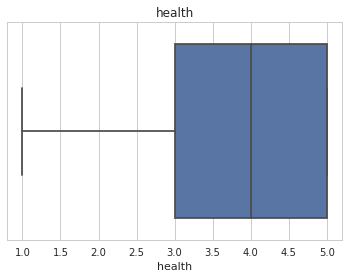

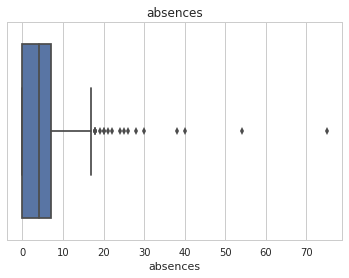

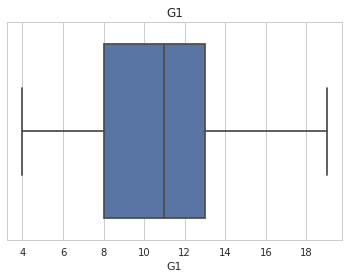

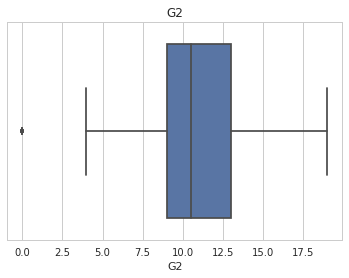

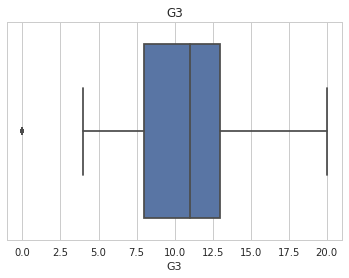

In [6]:
fxpy.histograms_bins(df)
fxpy.boxplots(df)

Las variables freetime, goout, y G1, tienen un comportamiento similar a una distribución normal. Traveltimes, failures, Dalc, Walc y absences tienen sus datos distribuidos mayoritariamente bajo la media, con el caso especial de'absences' que presenta su mayor distribución en el valor 0.  
Revisando los boxplots, se ven pocos outliers, excepto en la variable 'absences', que presenta su media cercana a 0 pero muchos valores que se escapan de ésta.
Ahora revisaremos las variables categóricas

In [7]:
fxpy.valores_ds1(df)

school :
GP    247
MS     37
Name: school, dtype: int64


sex :
F    147
M    137
Name: sex, dtype: int64


address :
U    214
R     70
Name: address, dtype: int64


famsize :
GT3    209
LE3     75
Name: famsize, dtype: int64


Pstatus :
T    257
A     27
Name: Pstatus, dtype: int64


Mjob :
other       103
services     68
teacher      44
at_home      43
health       26
Name: Mjob, dtype: int64


Fjob :
other       159
services     80
teacher      21
health       13
at_home      11
Name: Fjob, dtype: int64


reason :
course        102
home           78
reputation     77
other          27
Name: reason, dtype: int64


guardian :
mother    200
father     60
other      24
Name: guardian, dtype: int64


schoolsup :
no     246
yes     38
Name: schoolsup, dtype: int64


famsup :
yes    174
no     110
Name: famsup, dtype: int64


paid :
no     158
yes    126
Name: paid, dtype: int64


activities :
yes    148
no     136
Name: activities, dtype: int64


nursery :
yes    223
no      61
Name: nurs

In [12]:
df_final = pd.get_dummies(df, columns=['school','sex','address','famsize', 'Pstatus','Mjob','Fjob', 'reason', 'guardian', 'schoolsup','famsup','paid','activities','nursery','higher','internet','romantic'], drop_first=True)

Ocupamos la función get_dummies de pandas para binarizar las variables, utilizamos el parámetro drop_first=True, para solo traer K-1 agrupaciones y evitar multicolinealidad  
### Modelación descriptiva  
Decidimos utilizar una regresión lineal para predecir la variable binaria 'income'

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'romantic_yes'],
      dtype='object')